In [1]:
import requests
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime
from itertools import product

%matplotlib inline

# ignore matplotlib warning
plt.rcParams.update({'figure.max_open_warning': 0})

## Data acquisition

### Download data

In [2]:
def date2str(date):
    return datetime.strftime(date, "%Y-%m-%d")

def str2date(date):
    return datetime.strptime(date, "%Y-%m-%d")

In [3]:
counters = {
    "search": 1839500,
    "yandex": 1839501,
}

def process_browser(browser):
    return "yabrowser" if browser == "chrome/chrome-yab" else browser

def get_url(counter_id, date):
    return "https://top.mail.ru/json/browsersdynamics.hc?id={counter_id}&amp;period=0&amp;date={date}&amp;gender=0&amp;agegroup=0&amp;showtype=visitors&amp;aggregation=sum&amp;&sids=chrome,firefox,opera,msie,chrome/chrome-yab&ytype=hits&gtype=line&legend=1&xtype=datetime".format(
        counter_id=counter_id,
        date=date
    )

def get_counter_data(counter_id, date):
    url = get_url(counter_id, date)
    response = requests.get(url)
    return json.loads(response.text)

def parse_json(json):
    results = []
    
    for series in json["series"]:
        data = pd.DataFrame(series["data"])
        data["browser"] = process_browser(series["sid"])
        results.append(data)
    
    return pd.concat(results)

def get_data(date):
    results = []
    
    for counter, counter_id in counters.items():
        raw_data = get_counter_data(counter_id, date)
        data = parse_json(raw_data)
        data["se"] = counter
        results.append(data)
        
    return pd.concat(results)

### Build CSV

In [4]:
def build_csv(data, file):
    with open(file, "w") as out:
        out.write("date,se,browser,hits\n")
        
        for _, row in data.iterrows():
            out.write("{},{},{},{}\n".format(row["date"], row["se"], row["browser"], row["y"]))

In [ ]:
data = get_data(date2str(datetime(year=2017, month=11, day=1)))

In [ ]:
build_csv(data, "data.csv")

## Data processing

In [5]:
sources = {"yandex", "search"}
browsers = {"chrome", "firefox", "msie", "opera", "yabrowser"}
data = pd.read_csv("data.csv")

### Utils

In [6]:
def date_range(data, start, end):
    return (data.date >= start) & (data.date <= end)

def sb_range(data, source, browser):
    return (data.se == source) & (data.browser == browser)
    
def get_value(data, source, browser, date, col):
    return data.loc[sb_range(data, source, browser) & date_range(data, date, date)].iloc[0][col]

def set_value(data, source, browser, date, col, value):
    data.loc[sb_range(data, source, browser) & date_range(data, date, date), col] = value

### Visualizing

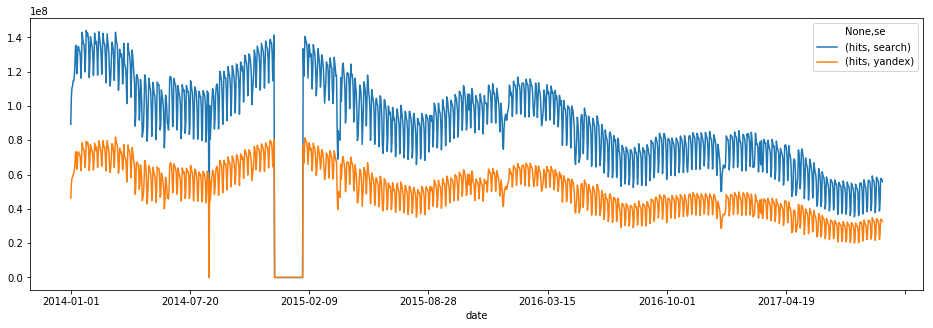

In [7]:
data.pivot_table(index="date", columns="se", aggfunc=sum).plot(figsize=(16,5))

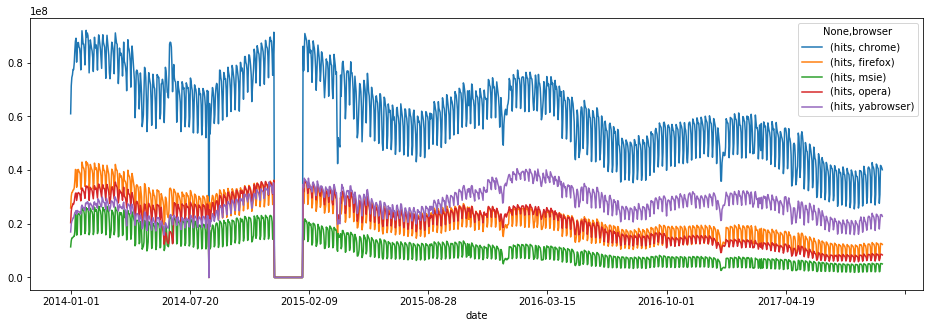

In [8]:
data.pivot_table(index="date", columns="browser", aggfunc=sum).plot(figsize=(16,5))

### Problems

#### Problem #1

Some dates are missed.

In [9]:
np.unique(data.loc[date_range(data, "2014-12-25", "2015-01-01")].date)

array(['2014-12-25', '2014-12-26', '2014-12-27', '2015-01-01'], dtype=object)

Add missing dates.

In [10]:
dates = ["2014-12-28", "2014-12-29", "2014-12-30", "2014-12-31"]

rows = []

for date in dates:
    for (source, browser) in product(sources, browsers):
        rows.append([date, source, browser, 0.0])

data = data.append(pd.DataFrame(rows, columns=["date", "se", "browser", "hits"])).reset_index(drop=True)

In [11]:
data = data.sort_values("date")

Create clean data.

In [12]:
cdata = data.copy()

#### Problem #2

It's a zero value on 2014-08-21.

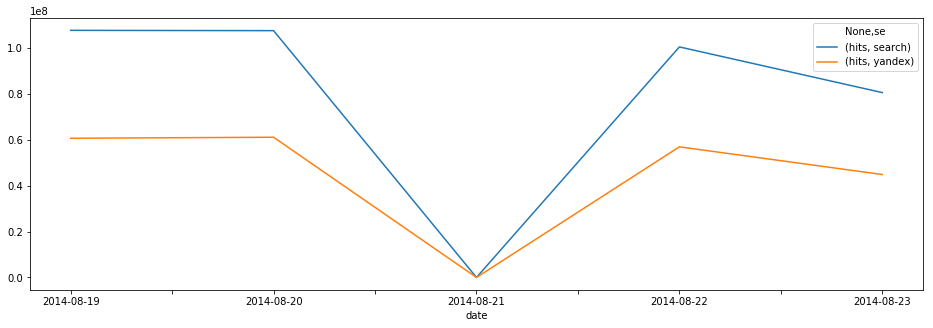

In [13]:
data.loc[date_range(data, "2014-08-19", "2014-08-23")]\
    .pivot_table(index="date", columns=["se"], aggfunc=sum)\
    .plot(figsize=(16,5))

In [14]:
for (source, browser) in product(sources, browsers):
    prev_value = get_value(data, source, browser, "2014-08-20", "hits")
    next_value = get_value(data, source, browser, "2014-08-22", "hits")
    set_value(cdata, source, browser, "2014-08-21", "hits", (prev_value + next_value) / 2)

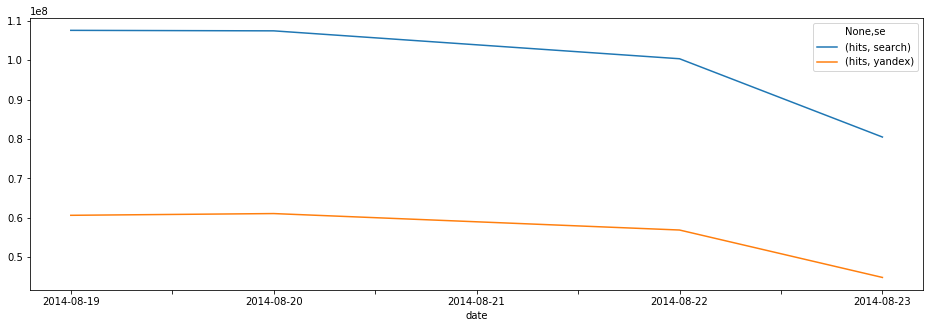

In [15]:
cdata.loc[date_range(cdata, "2014-08-19", "2014-08-23")]\
    .pivot_table(index="date", columns=["se"], aggfunc=sum)\
    .plot(figsize=(16,5))

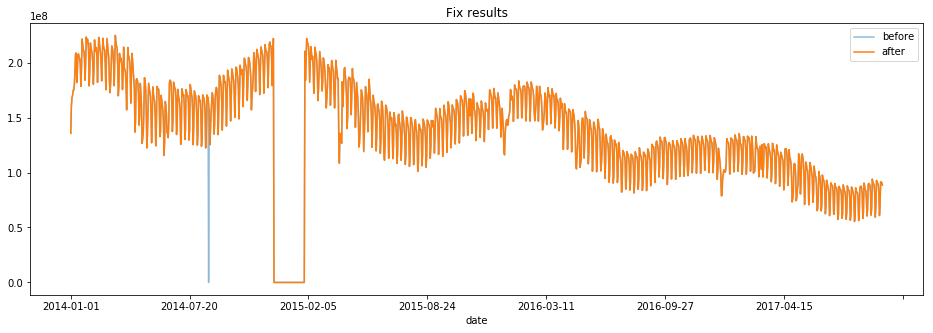

In [16]:
df = pd.DataFrame({
    "before": data.pivot_table(index="date", aggfunc=sum)["hits"],
    "after": cdata.pivot_table(index="date", aggfunc=sum)["hits"],
})

ax = df["before"].plot(alpha=0.5, figsize=(16,5), title="Fix results")
df["after"].plot(ax=ax)
plt.legend()

#### Problem #3

We can see gap from 2014-12-09 to 2015-01-29.

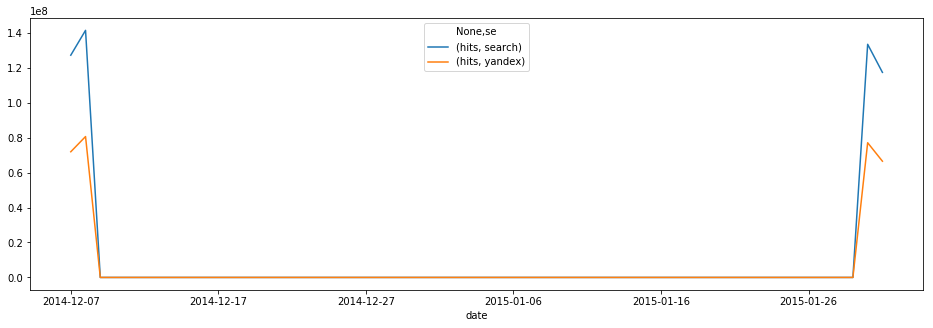

In [17]:
data.loc[date_range(data, "2014-12-07", "2015-01-31")]\
    .pivot_table(index="date", columns=["se"], aggfunc=sum)\
    .plot(figsize=(16,5))

Let's look at the values of the next year.

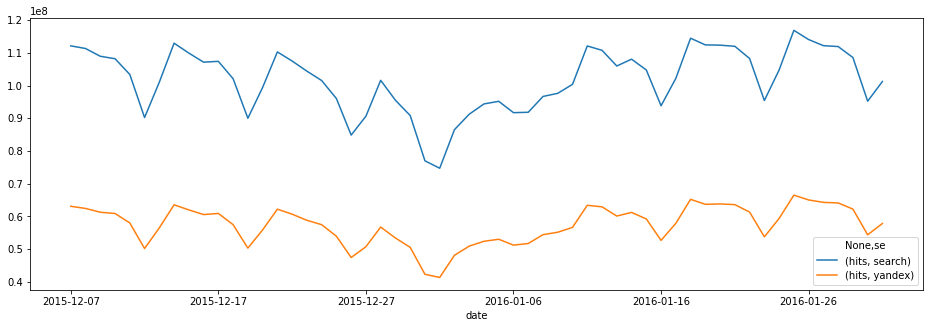

In [18]:
data.loc[date_range(data, "2015-12-07", "2016-01-31")]\
    .pivot_table(index="date", columns=["se"], aggfunc=sum)\
    .plot(figsize=(16,5))

Consider the month before and after the gap. <br>
Copy the next year's values with a shift.

In [19]:
before_1 = data.loc[date_range(data, "2014-11-08", "2014-12-08")]\
               .pivot_table(index="date", columns=["se", "browser"], aggfunc=sum)
after_1 = data.loc[date_range(data, "2015-01-30", "2015-02-28")]\
               .pivot_table(index="date", columns=["se", "browser"], aggfunc=sum)

In [20]:
before_2 = data.loc[date_range(data, "2015-11-08", "2015-12-08")]\
               .pivot_table(index="date", columns=["se", "browser"], aggfunc=sum)
after_2 = data.loc[date_range(data, "2016-01-30", "2016-02-28")]\
               .pivot_table(index="date", columns=["se", "browser"], aggfunc=sum)

In [21]:
def get_mean(data, source, browser):
    return np.mean(data["hits", source, browser])

for (source, browser) in product(sources, browsers):
    delta_before = get_mean(before_1, source, browser) - get_mean(before_2, source, browser)
    delta_after = get_mean(after_1, source, browser) - get_mean(after_2, source, browser)
    
    mask_0 = sb_range(data, source, browser)
    mask_1 = mask_0 & date_range(data, "2014-12-09", "2015-01-29")
    mask_2 = mask_0 & date_range(data, "2015-12-09", "2016-01-29")
    
    count = np.sum(mask_1)
    cdata.loc[mask_1, "hits"] = data.loc[mask_2, "hits"].values + np.linspace(delta_before, delta_after, count)

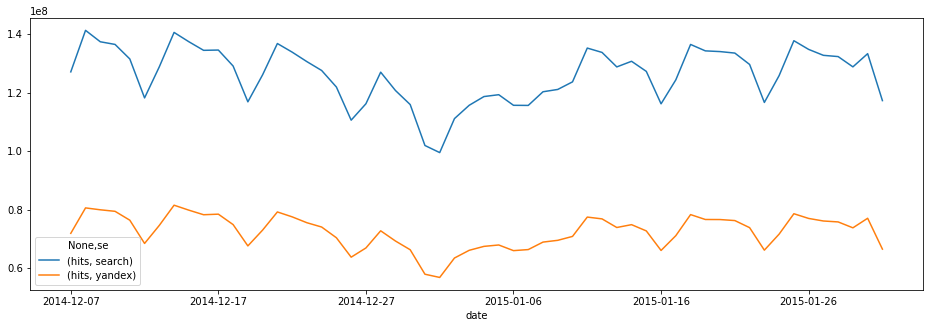

In [22]:
cdata.loc[date_range(cdata, "2014-12-07", "2015-01-31")]\
    .pivot_table(index="date", columns=["se"], aggfunc=sum)\
    .plot(figsize=(16,5))

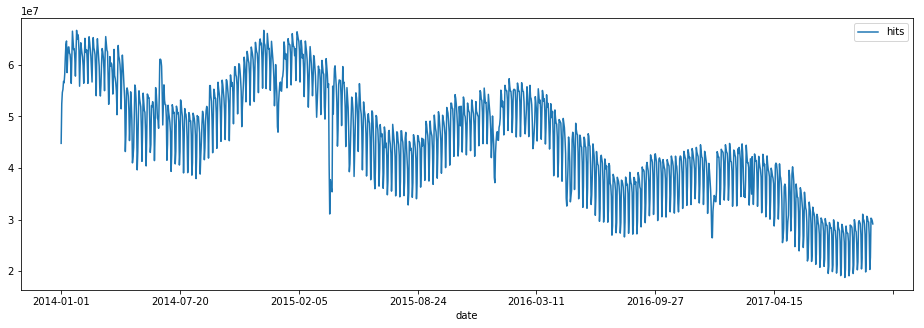

In [23]:
cdata.loc[sb_range(cdata, "search", "chrome")].pivot_table(index="date", aggfunc=sum).plot(figsize=(16,5))

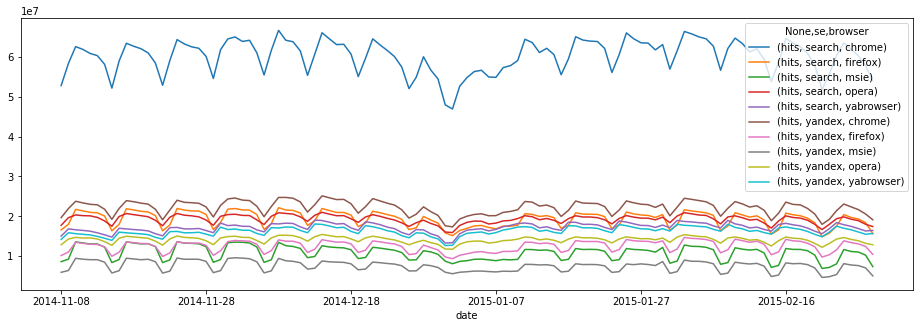

In [24]:
cdata.loc[date_range(cdata, "2014-11-08", "2015-02-28")]\
    .pivot_table(index="date", columns=["se", "browser"], aggfunc=sum)\
    .plot(figsize=(16,5))

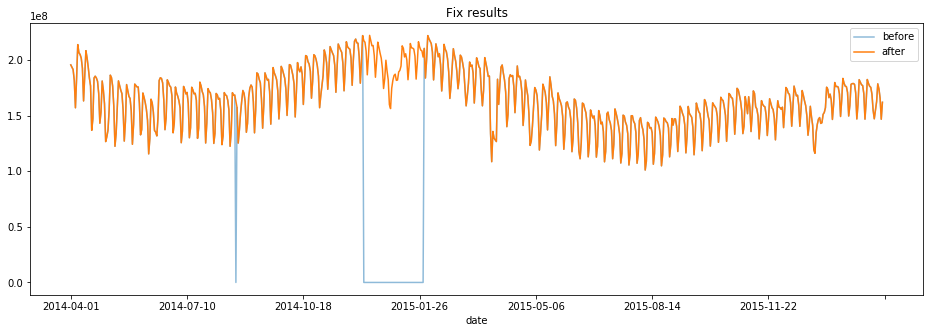

In [25]:
mask = date_range(data, "2014-04-01", "2016-02-28")

df = pd.DataFrame({
    "before": data[mask].pivot_table(index="date", aggfunc=sum)["hits"],
    "after": cdata[mask].pivot_table(index="date", aggfunc=sum)["hits"],
})

ax = df["before"].plot(alpha=0.5, figsize=(16,5), title="Fix results")
df["after"].plot(ax=ax)
plt.legend()

### STL

In [26]:
from forecast import forecast, stl, stldf, bind

In [27]:
bind(pd.DataFrame, stldf)
bind(pd.Series, stl, forecast)

#### Utils

In [28]:
def get_series(data, source, browser):
    return data[sb_range(data, source, browser)].set_index("date")["hits"]

def week_decomposition(series, source, browser):
    series_week_stl = stl(series, frequency=7)
    
    fig, ax = plt.subplots(figsize=(16,5))
    ax.set_title("STL week decompostition for ({}, {})".format(source, browser))
    series_week_stl.plot(ax=ax)
    plt.legend()
    
    return series_week_stl["hits_trend"], series_week_stl["hits_seasonal"], series_week_stl["hits_e"]

def plot_week_summary(series, series_week, series_week_e, source, browser):
    df_week = pd.DataFrame({
        "initial series": series,
        "initial series minus week seasonality": series_week + series_week_e
    })
    
    fig, ax = plt.subplots(figsize=(16,5))
    ax.set_title("Initial series and series without week seasonality ({}, {})".format(source, browser))
    df_week["initial series"].plot(ax=ax, alpha=0.5)
    df_week["initial series minus week seasonality"].plot(ax=ax)
    plt.legend()
    
def year_decomposition(series_week, source, browser):
    series_year_stl = stl(series_week, frequency=365)
    
    fig, ax = plt.subplots(figsize=(16,5))
    ax.set_title("STL year decompostition for ({}, {})".format(source, browser))
    series_year_stl.plot(ax=ax)
    plt.legend()
    
    return series_year_stl["hits_trend_trend"], series_year_stl["hits_trend_seasonal"], series_year_stl["hits_trend_e"]

def plot_year_summary(series_week, series_year, series_year_e, source, browser):
    df_year = pd.DataFrame({
        "initial series": series_week,
        "trend": series_year,
        "initial series minus year seasonality": series_year + series_year_e
    })

    fig, ax = plt.subplots(figsize=(16,5))
    ax.set_title("Initial series and series without year seasonality ({}, {})".format(source, browser))
    df_year["initial series"].plot(ax=ax, alpha=0.5)
    df_year[["initial series minus year seasonality", "trend"]].plot(ax=ax)
    plt.legend()
    
def plot_summary(series, series_week, series_year, source, browser):
    df_stl = pd.DataFrame({
        "series": series,
        "series_week": series_week,
        "series_year": series_year
    })

    fig, ax = plt.subplots(figsize=(16,5))
    ax.set_title("Series comparison for ({}, {})".format(source, browser))
    df_stl["series"].plot(ax=ax, alpha=0.5)
    df_stl[["series_week", "series_year"]].plot(ax=ax)
    plt.legend()

#### Series for all (source, browser)

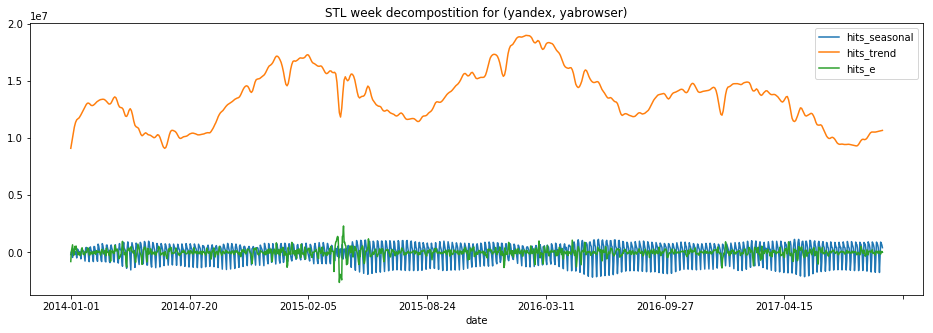

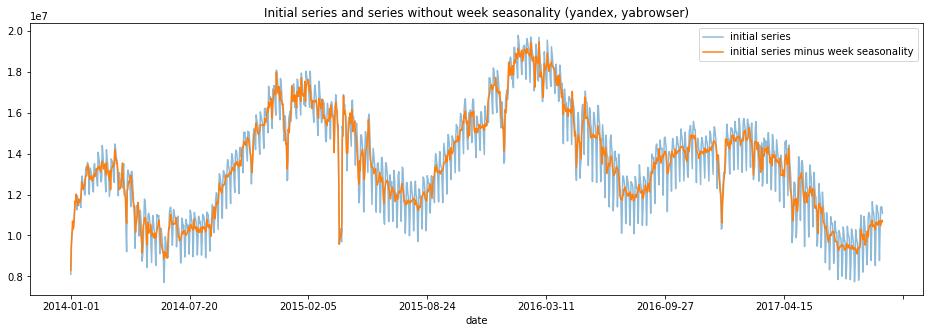

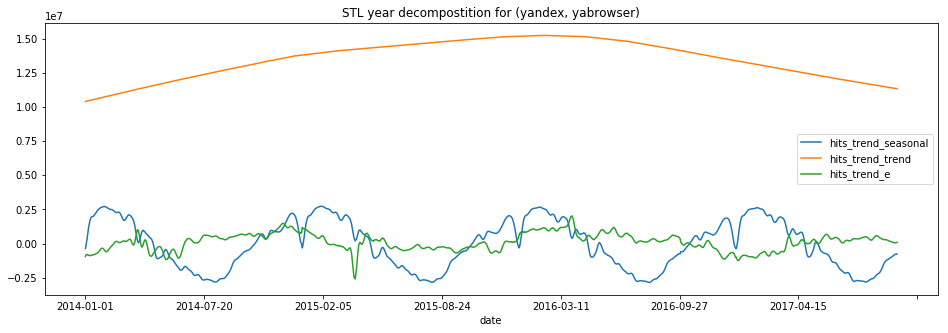

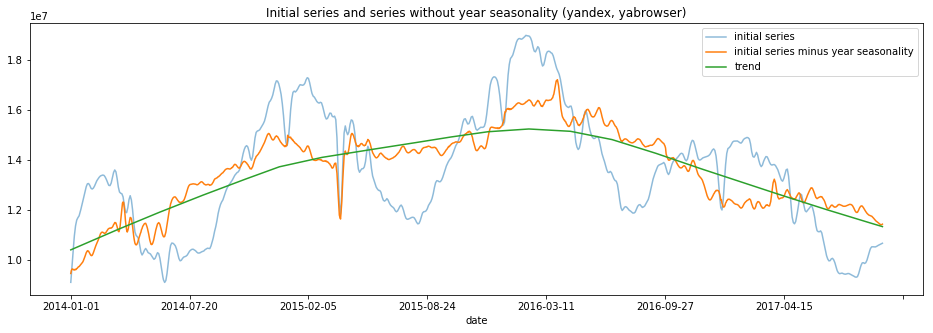

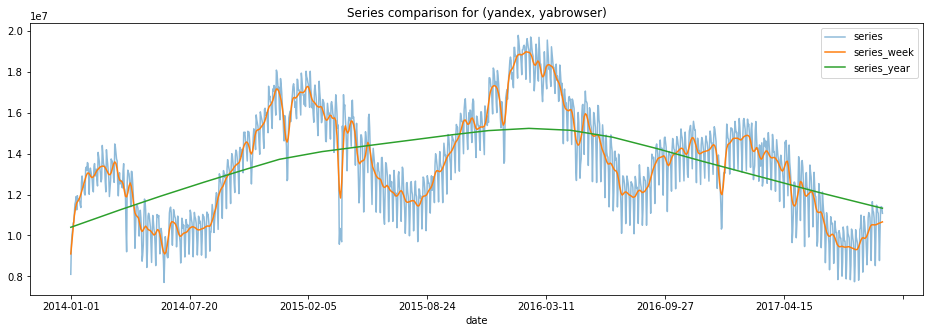

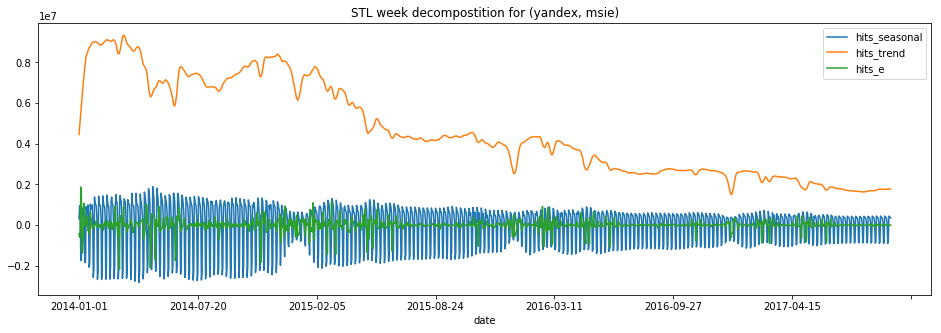

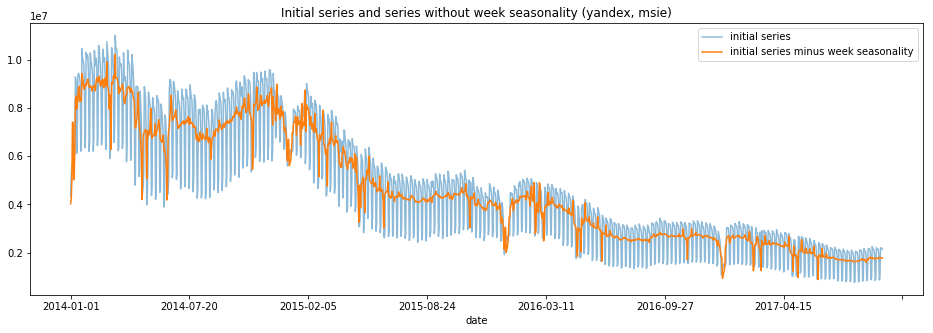

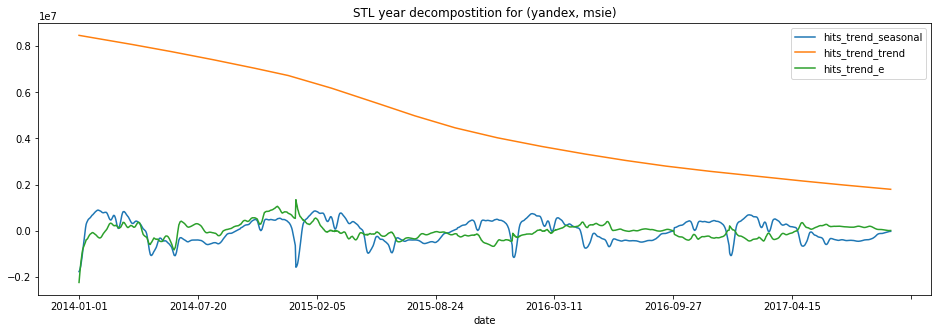

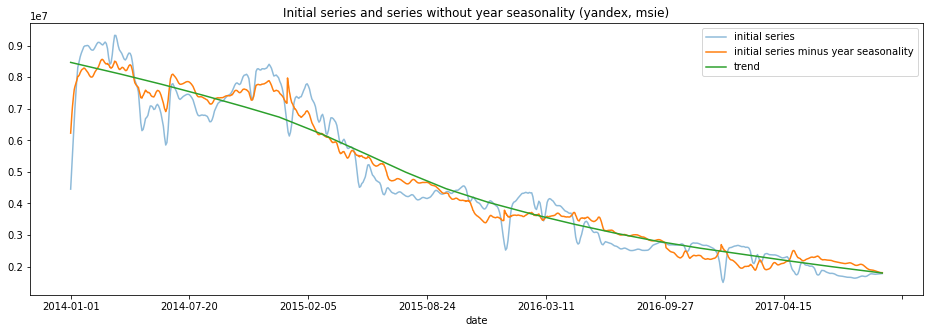

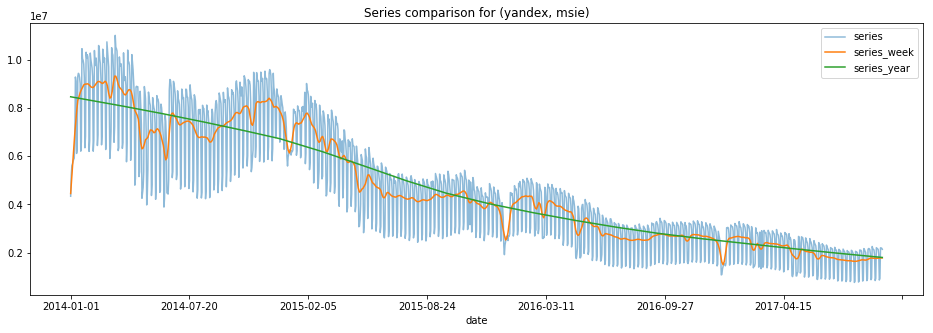

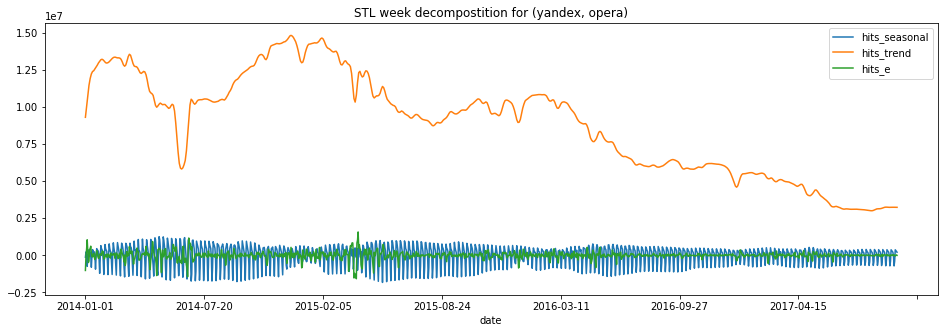

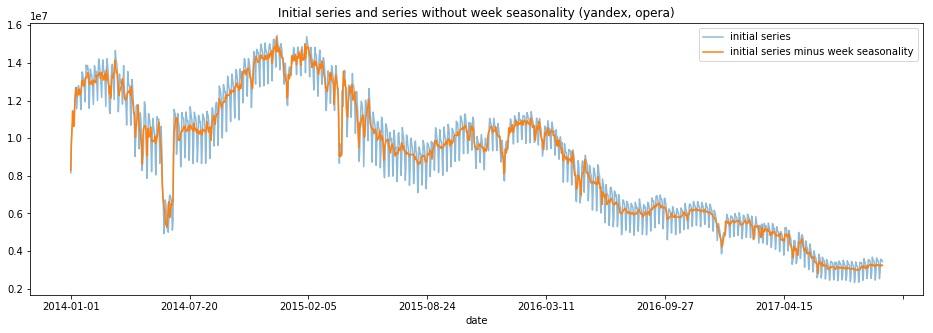

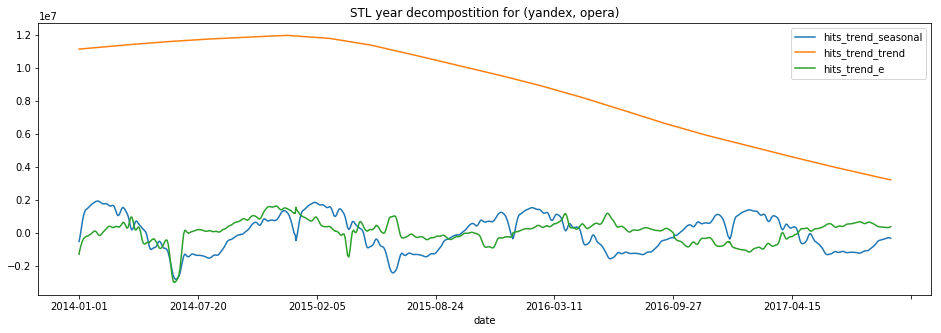

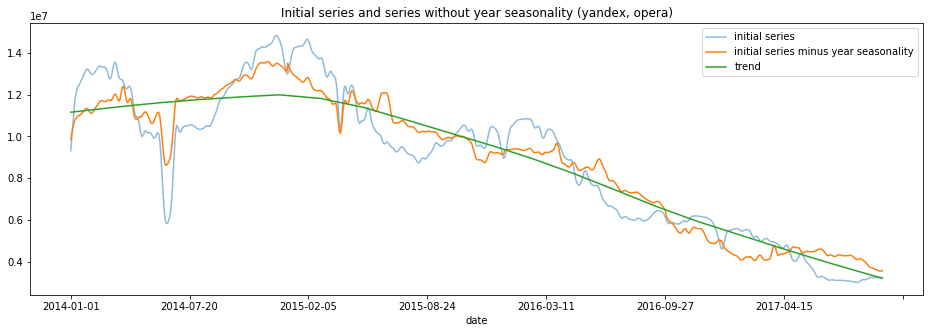

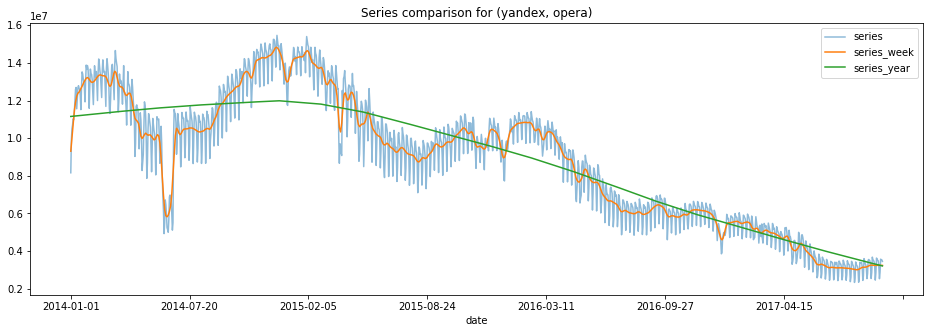

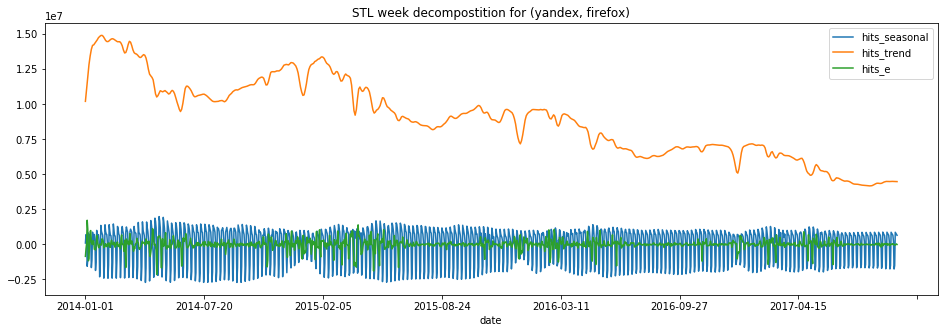

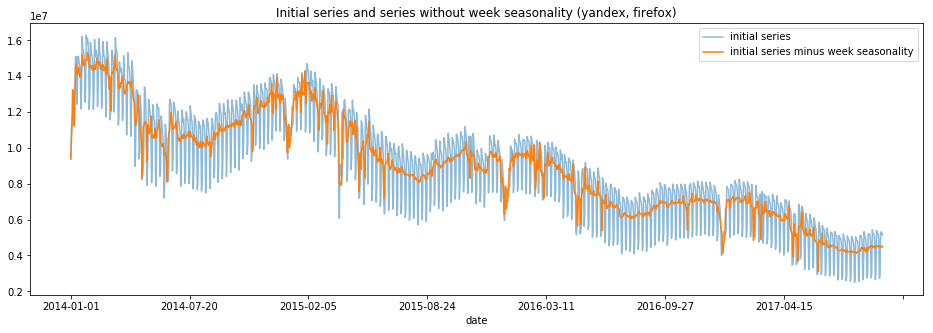

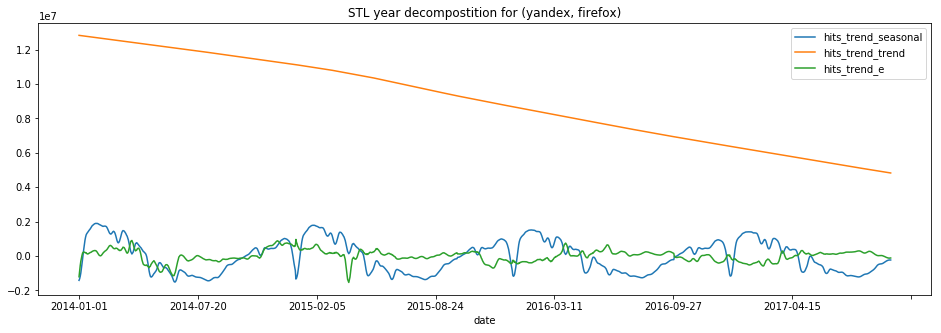

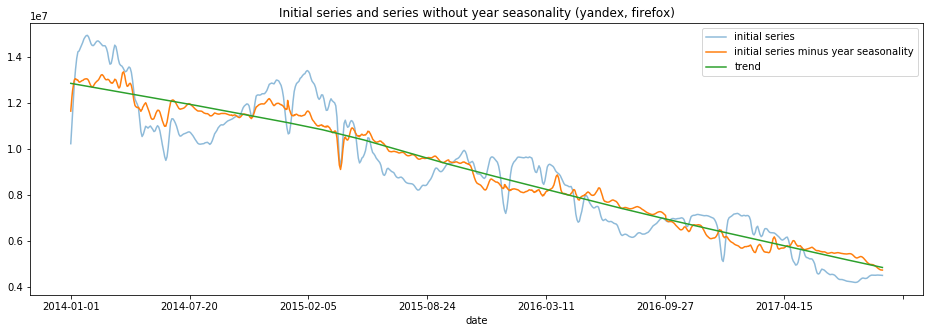

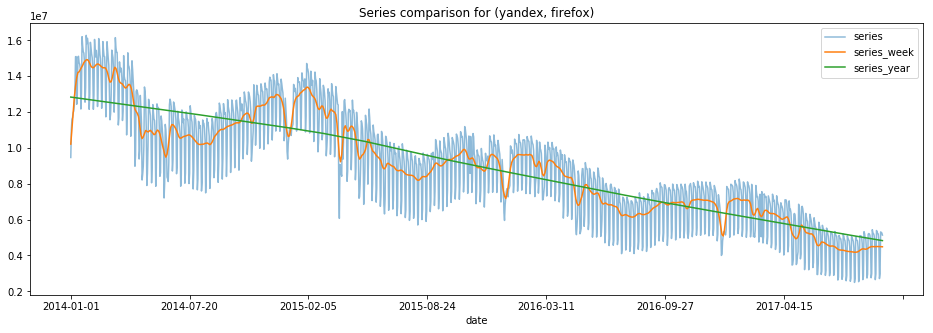

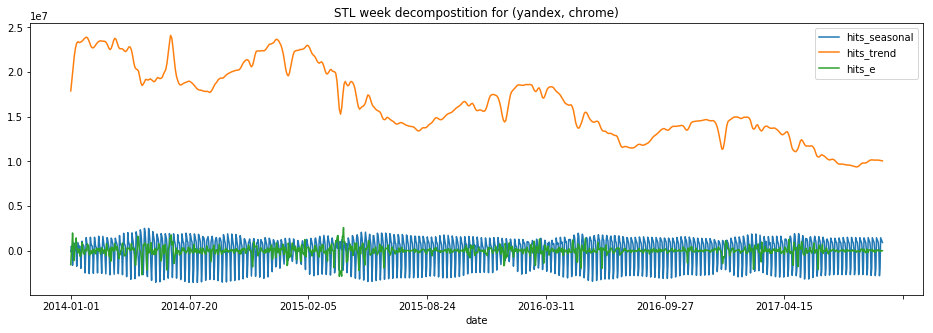

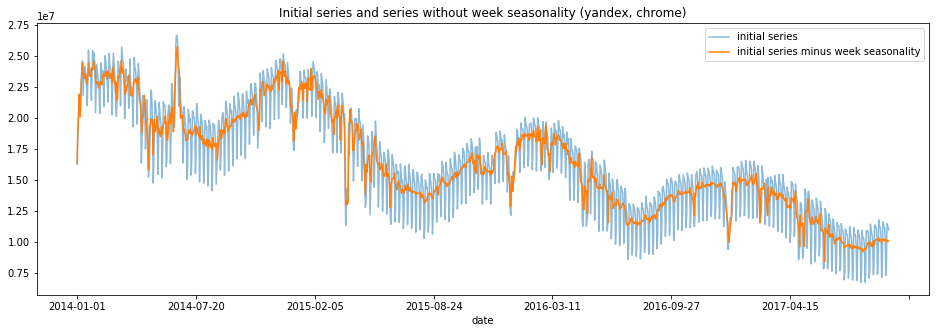

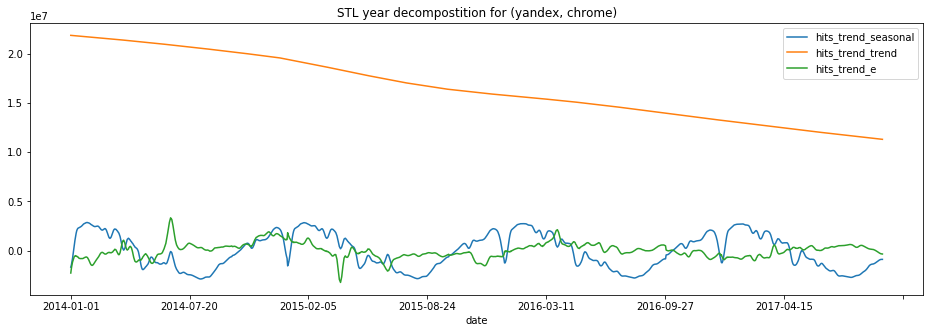

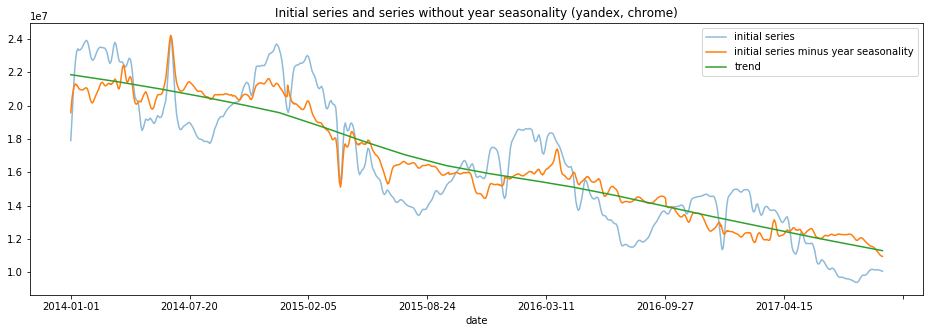

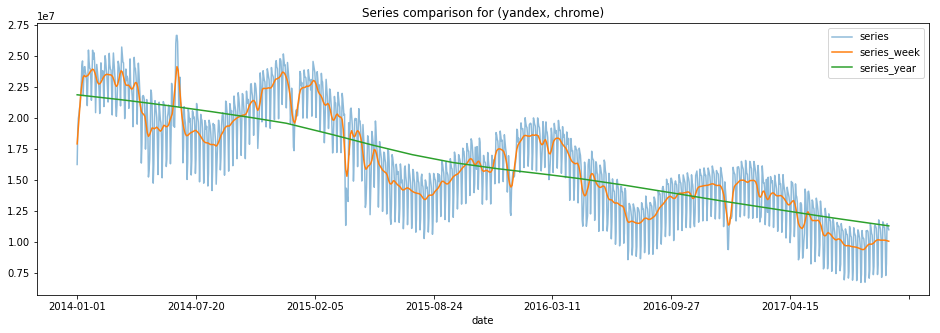

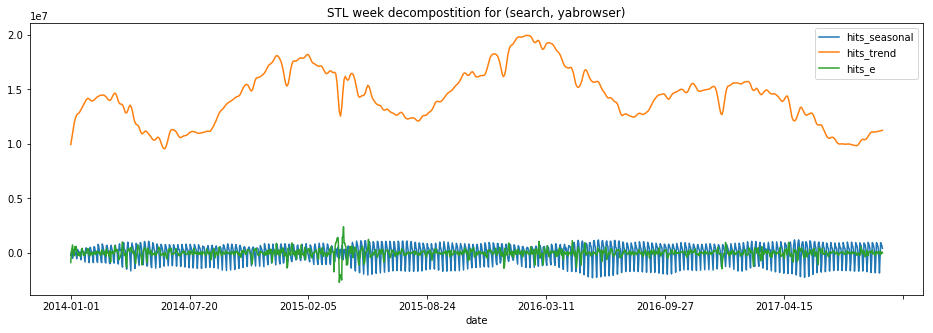

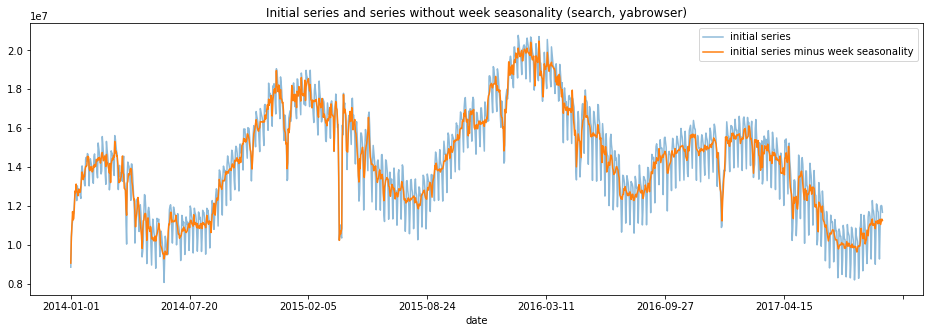

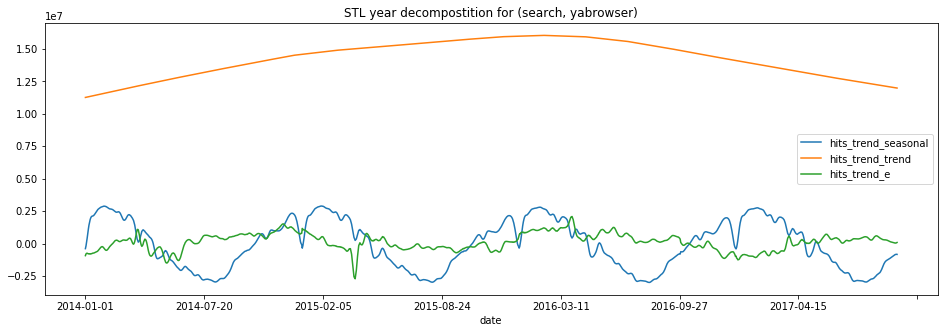

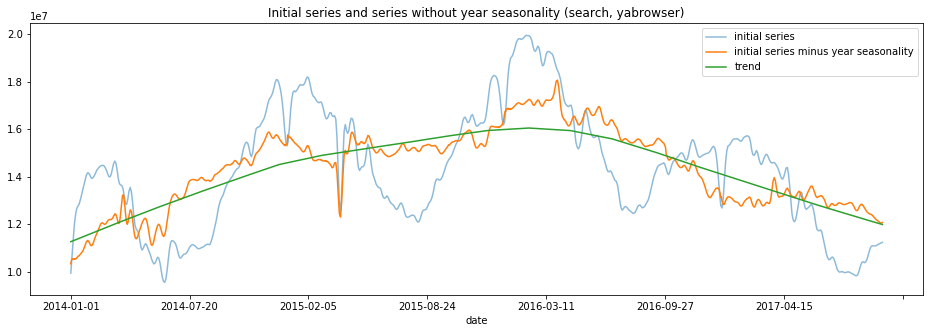

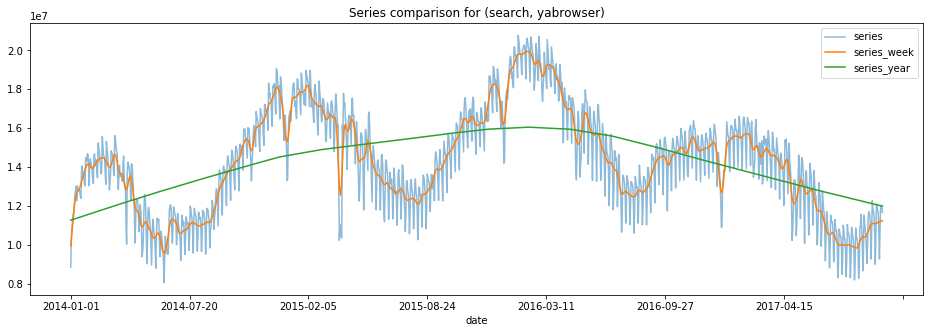

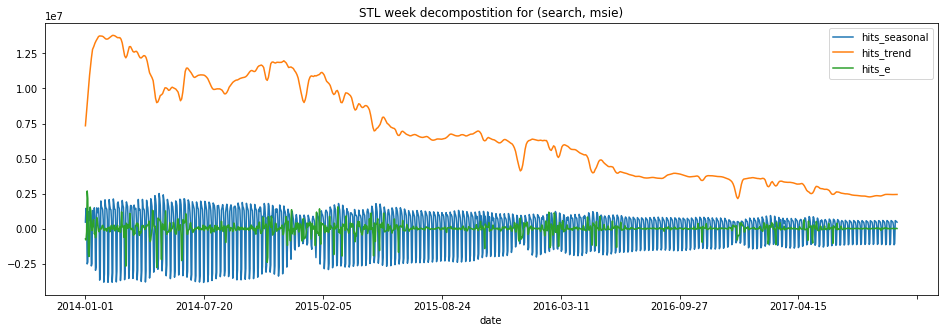

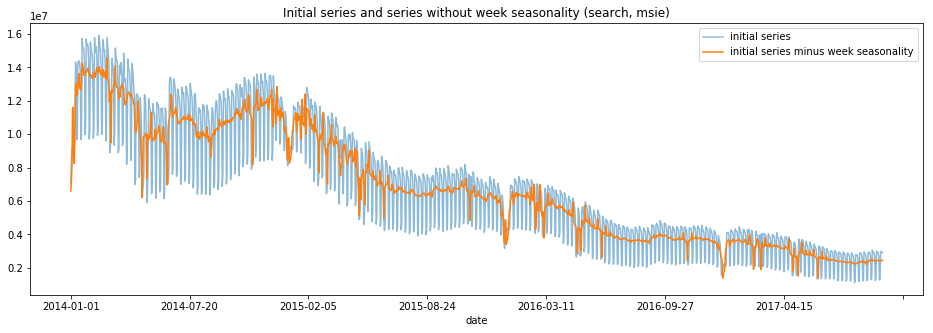

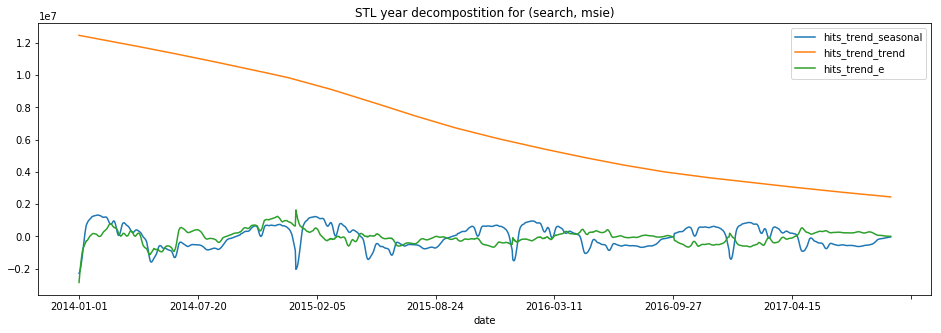

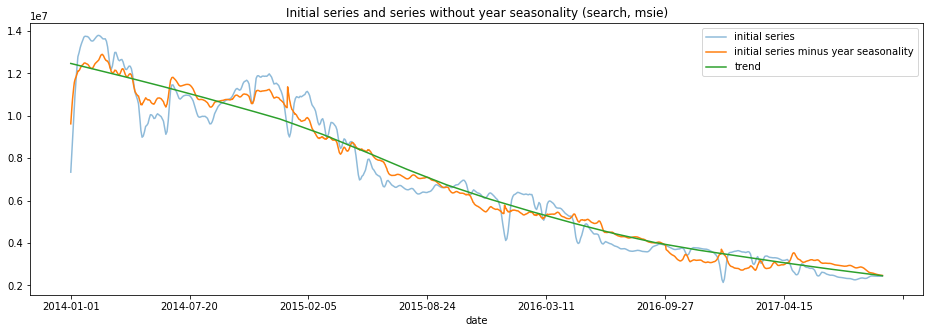

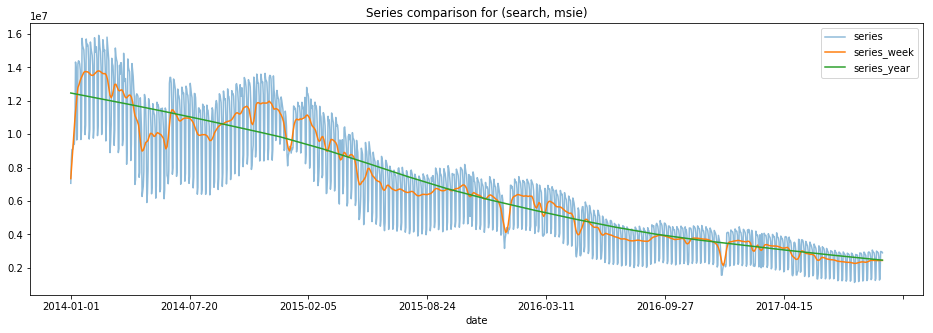

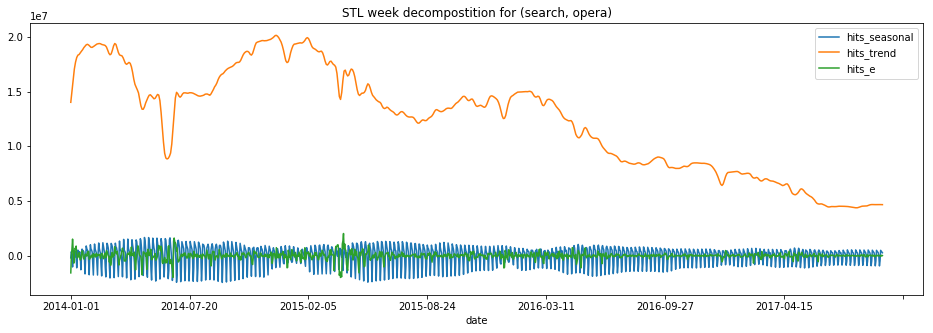

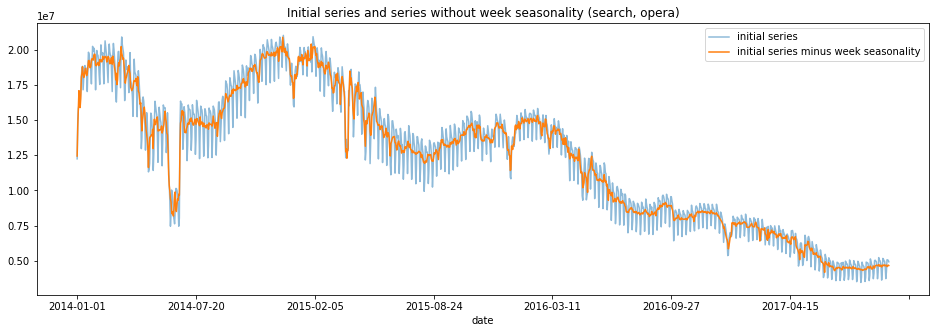

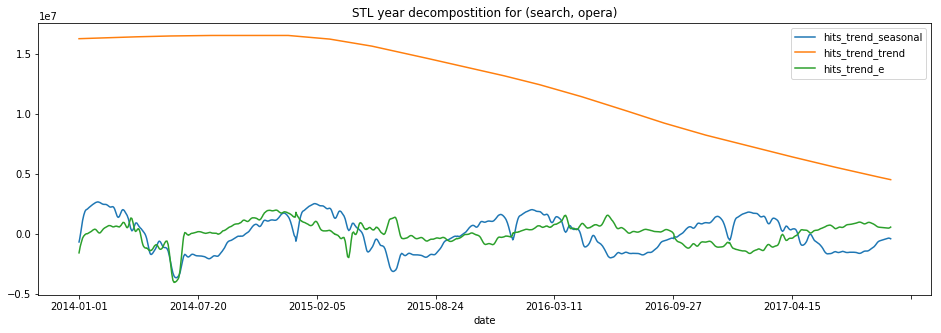

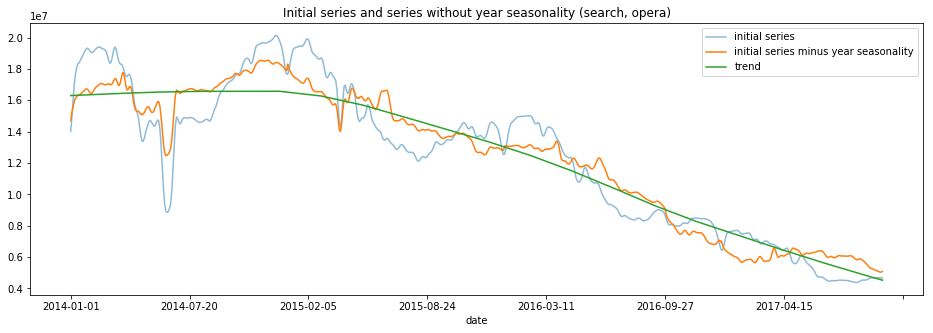

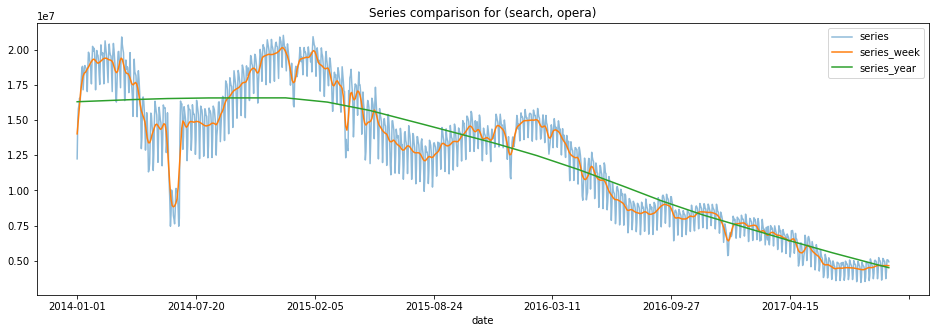

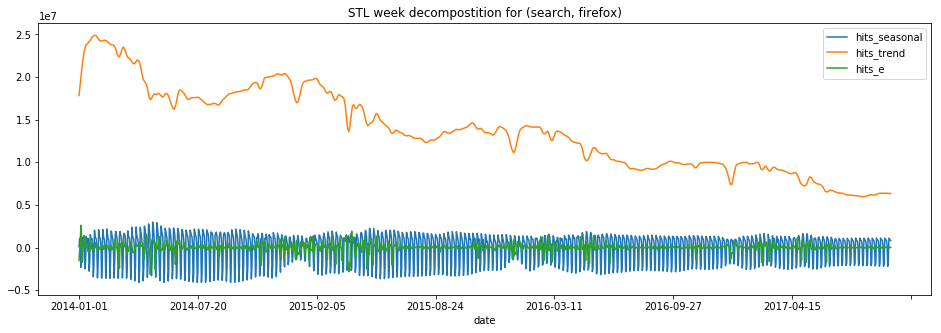

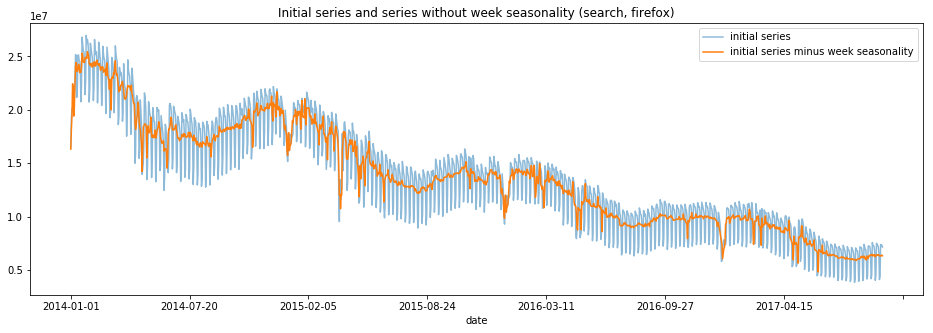

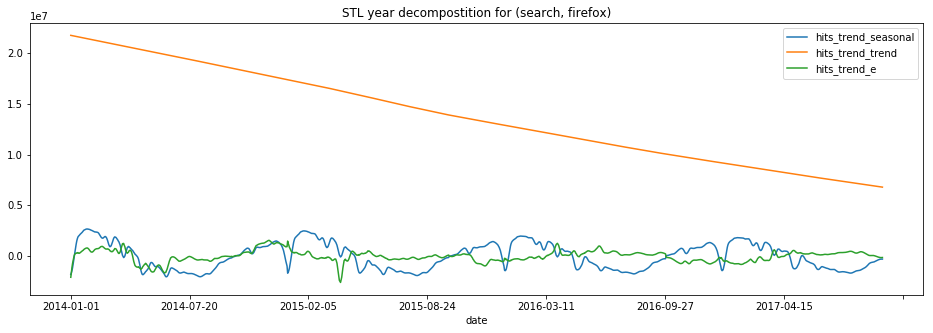

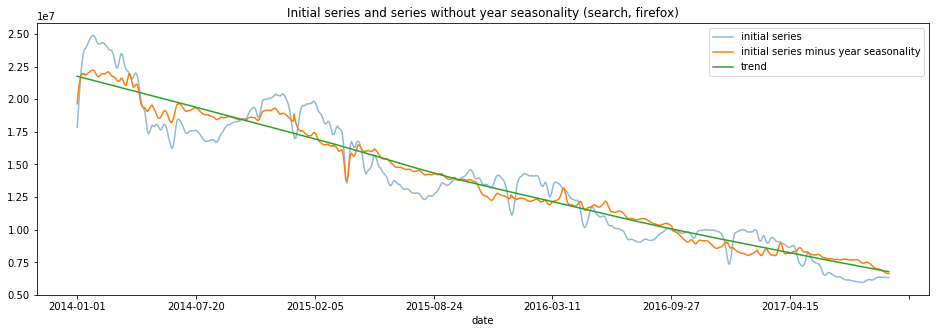

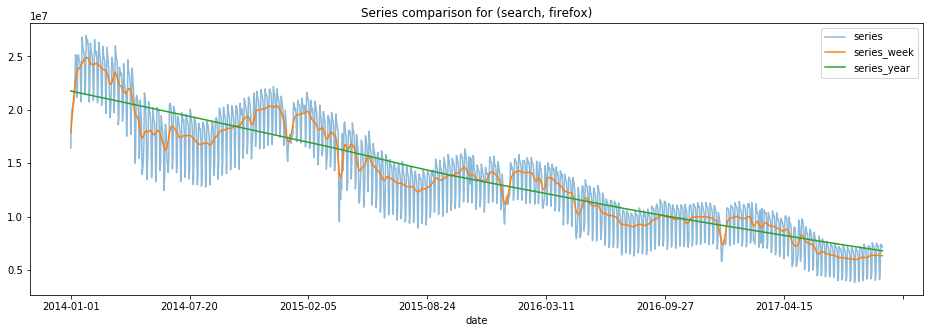

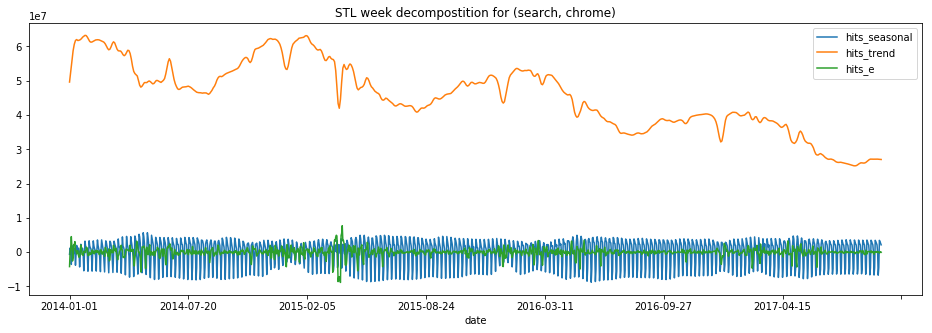

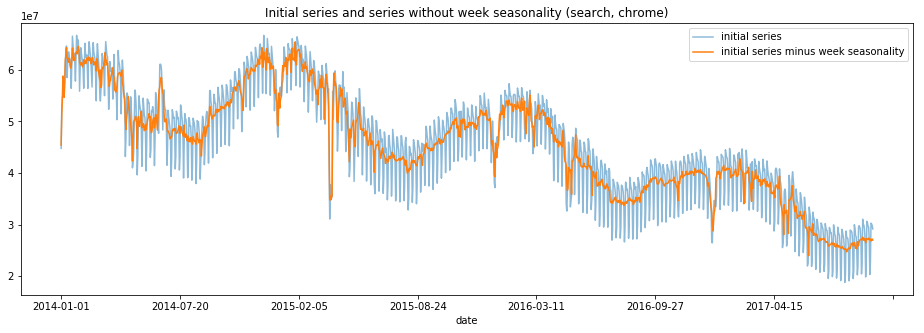

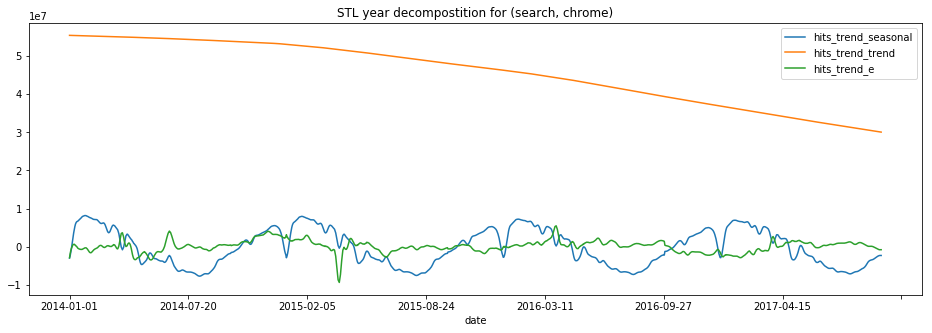

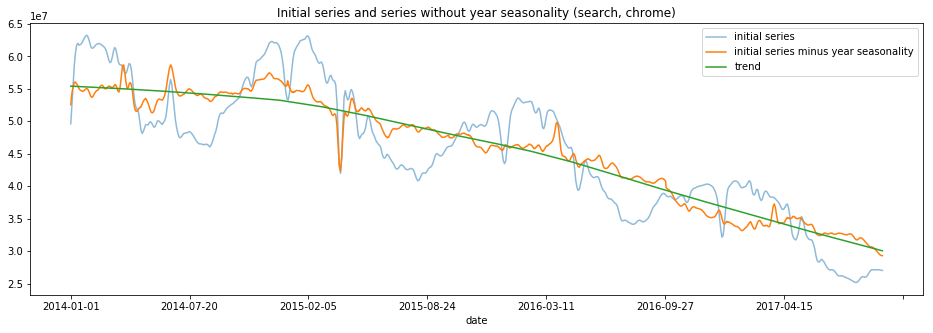

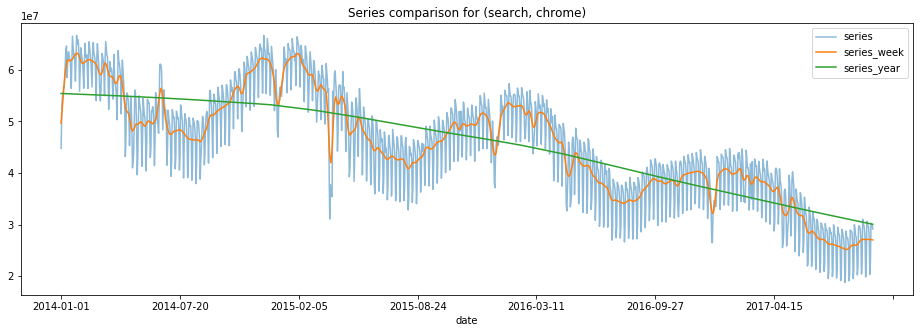

In [29]:
all_series = {}

for (source, browser) in product(sources, browsers):
    series = get_series(cdata, source, browser)
    
    series_week, series_week_s, series_week_e = week_decomposition(series, source, browser)
    plot_week_summary(series, series_week, series_week_e, source, browser)
    
    series_year, series_year_s, series_year_e = year_decomposition(series_week, source, browser)
    plot_year_summary(series_week, series_year, series_year_e, source, browser)
    
    plot_summary(series, series_week, series_year, source, browser)
    
    # save new series
    all_series[(source, browser)] = {
        "week_trend": series_week,
        "week_seasonal": series_week_s,
        "year_trend": series_year,
        "year_seasonal": series_year_s
    }

### Build dataset

In [30]:
all_df = []

for (source, browser) in product(sources, browsers):
    mask = sb_range(cdata, source, browser)
    series = all_series[(source, browser)]
    
    df = pd.DataFrame({
        "date": cdata.loc[mask, "date"],
        "se": source,
        "browser": browser,
    })
    
    df["hits"] = data.loc[mask, "hits"]
    df["hits_fixed"] = cdata.loc[mask, "hits"]
    df.set_index("date", inplace=True)
    
    df["hits_week_trend"] = series["week_trend"]
    df["hits_week_seasonal"] = series["week_seasonal"]
    df["hits_year_trend"] = series["year_trend"]
    df["hits_year_seasonal"] = series["year_seasonal"]
    
    all_df.append(df)
    
dataset = pd.concat(all_df)

Save the dataset.

In [31]:
dataset.to_csv("processed_data.csv")

## Summary

In [32]:
data = pd.read_csv("processed_data.csv")

In [33]:
data.head()

date    browser      se        hits  hits_fixed  hits_week_trend  \
0  2014-01-01  yabrowser  yandex   8102110.0   8102110.0     9.100955e+06   
1  2014-01-02  yabrowser  yandex   9548842.0   9548842.0     9.420372e+06   
2  2014-01-03  yabrowser  yandex  10025620.0  10025620.0     9.739789e+06   
3  2014-01-04  yabrowser  yandex  10261810.0  10261810.0     1.005054e+07   
4  2014-01-05  yabrowser  yandex  10612270.0  10612270.0     1.036129e+07   

   hits_week_seasonal  hits_year_trend  hits_year_seasonal  
0      -193917.878012     1.040014e+07      -354249.917510  
1        49914.088765     1.041047e+07      -159569.456492  
2       -86221.335367     1.042081e+07       111423.701815  
3      -447379.404417     1.043114e+07       413630.411450  
4       295445.708840     1.044147e+07       745745.494730

### Utils

In [34]:
def build_share(statistics):
    total = statistics.sum(axis="columns")
    return 100 * statistics.divide(total, axis="rows")

def build_share_se(yandex, search):
    return pd.DataFrame({
        "yandex": 100 * yandex / search,
        "other": 100 * (search - yandex) / search
    })

def plot_share(share, title):
    fig, ax = plt.subplots(figsize=(16,5))
    ax.set_title(title)
    ax.set_ylabel("share")
    share.plot(ax=ax)

### Yandex share vs. Other share

Let's compare the share of Yandex with the share of other search engines.

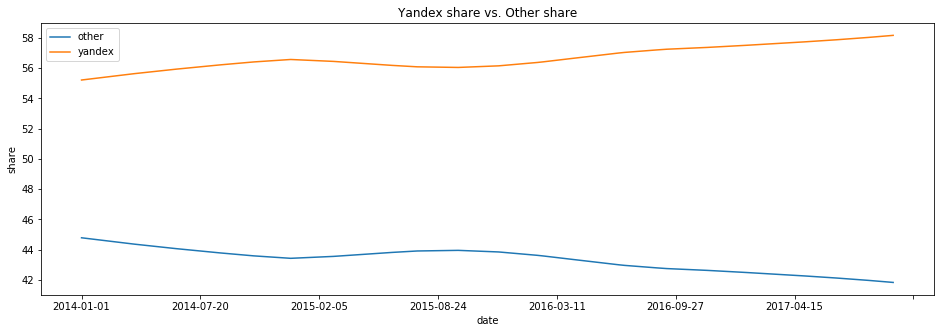

In [36]:
table = data.pivot_table(index="date", columns="se", aggfunc=sum)

yandex = table["hits_year_trend", "yandex"]
search = table["hits_year_trend", "search"]

share = build_share_se(yandex, search)
plot_share(share, "Yandex share vs. Other share")

As we can see, the share of Yandex is increasing.

### Shares of search engines

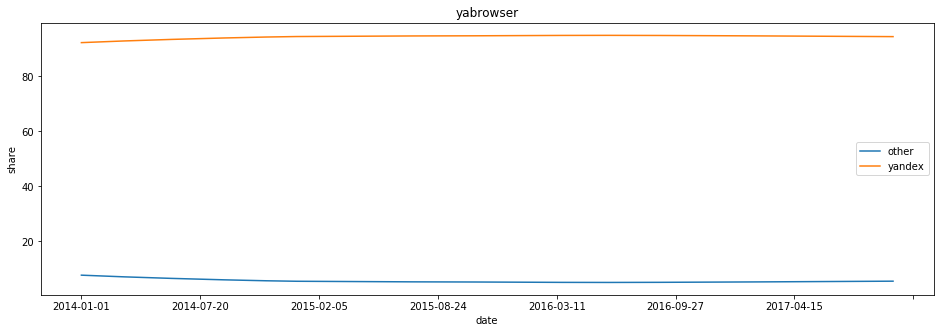

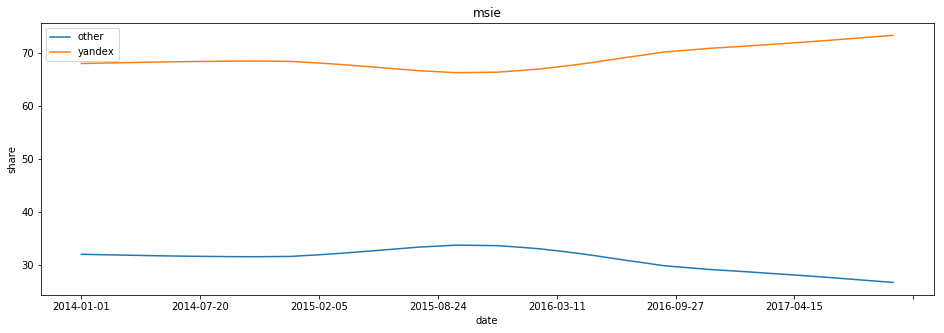

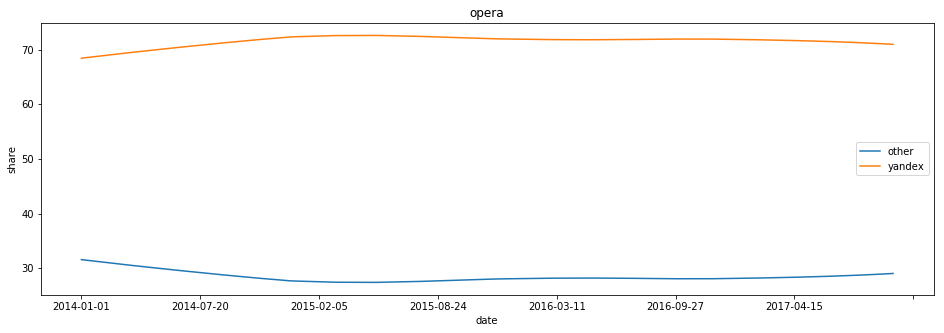

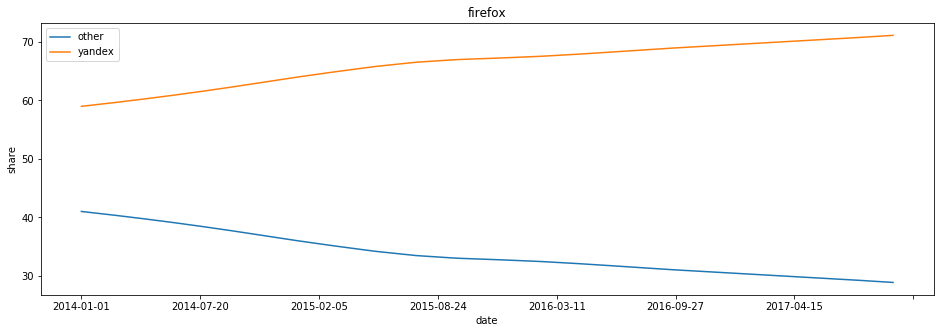

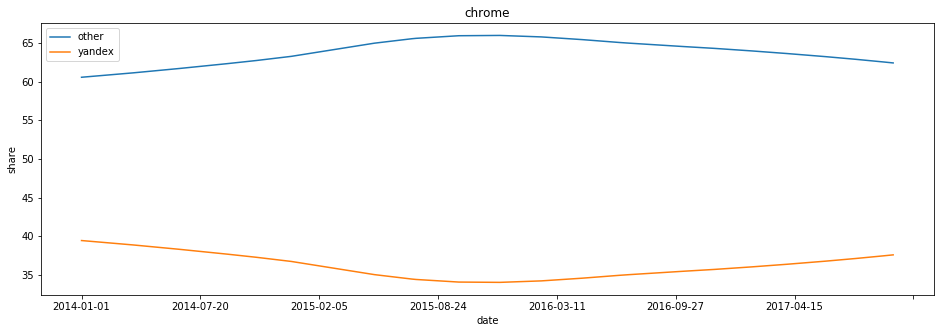

In [37]:
table = data.pivot_table(index="date", columns=["se", "browser"], aggfunc=sum)

for browser in browsers:
    yandex = table["hits_year_trend", "yandex", browser]
    search = table["hits_year_trend", "search", browser]
    
    share = build_share_se(yandex, search)
    plot_share(share, browser)

As we can see, users of almost all browsers use Yandex more than other search engines.

Chrome users prefer other search engines, but Yandex share has been increasing since 2016.

### Browsers' share for Yandex

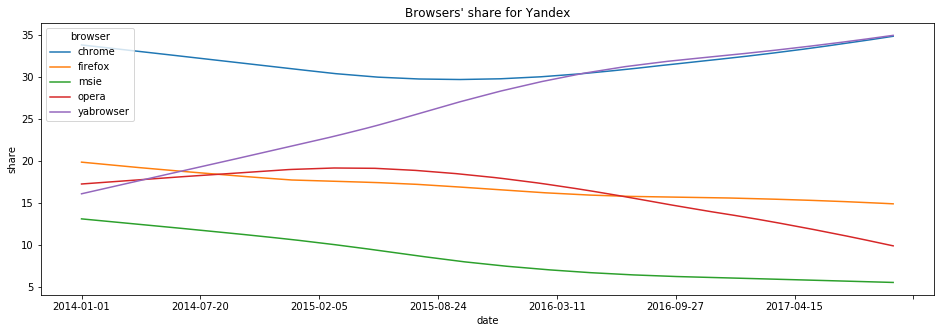

In [38]:
share = build_share(table["hits_year_trend", "yandex"])
plot_share(share, "Browsers' share for Yandex")

As we can see, shares of Firefox, Internet Explorer and Opera are decreasing, and the share of Yandex browser is growing rapidly.

### Browsers' share for other search engines

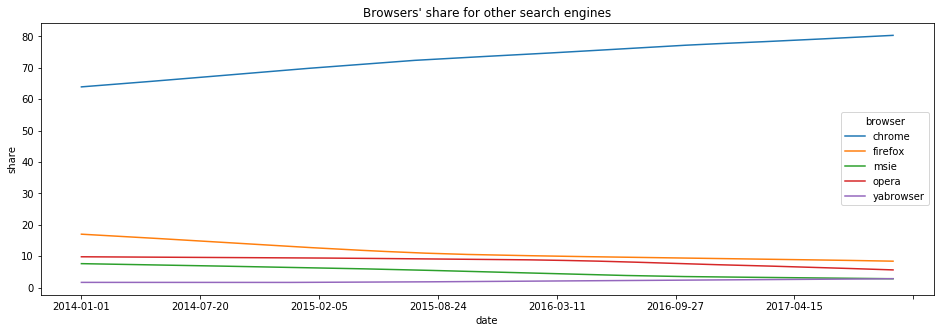

In [39]:
share = build_share(table["hits_year_trend", "search"] - table["hits_year_trend", "yandex"])
plot_share(share, "Browsers' share for other search engines")

Shares of Firefox, Internet Explorer, Opera are decreasing, and the share of Google Chrome is growing.  <br>
The share of Yandex is insignificant.